In [1]:
import torch
from utils import show_images_rgb, show_outputs_rgb
from models import *
from dataset import MNISTsuperimposed
from torchvision import transforms
from torch.utils.data import DataLoader
from utils import Downsample, Noise, show_outputs

In [2]:
UpTransformer = UpsamplingTransformer(
    d_model=288,
    encoder_feedforward=1024,
    decoder_feedforward=1024,
    encoder_heads=288,
    decoder_heads=288,
    num_decoder_layers=1,
    num_encoder_layers=1,
    upscale=1
)

TRANSFORMER_PATH = './checkpoints/filename'

RNN_PATH = './checkpoints/RNNFinal.pt'

UpTransformer.load_state_dict(torch.load(TRANSFORMER_PATH))


UpRNN = RNN()
UpRNN.load_state_dict(torch.load(RNN_PATH))


# Now let's check the RNN
print('Parameters for RNN:', sum([parameter.numel() for parameter in UpRNN.parameters()]))
print('Parameters for Transformer:', sum([parameter.numel() for parameter in UpTransformer.parameters()]))


Parameters for RNN: 2846224
Parameters for Transformer: 2301865


In [3]:
transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor(),
     Downsample(),
     Noise(mean=0, dev=0.01)
     ])
target_transform= transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor()
     ])
test_supserimposed = MNISTsuperimposed("./MNIST data/test", train = False, download = True, transform = transform, target_transform=target_transform)

Using path ./permutations/permutation_test.pkl


In [4]:
testset = DataLoader(test_supserimposed, batch_size=64, shuffle=True)
inputs,targets = next(iter(testset))
TransformerOutputs = UpTransformer(inputs)

RNNOutputs = UpRNN(inputs, flag = False)
RNNOutputs = torch.cat([RNNOutputs[1].reshape(-1,1,28,28), RNNOutputs[2].reshape(-1,1,28,28)], axis = 1)


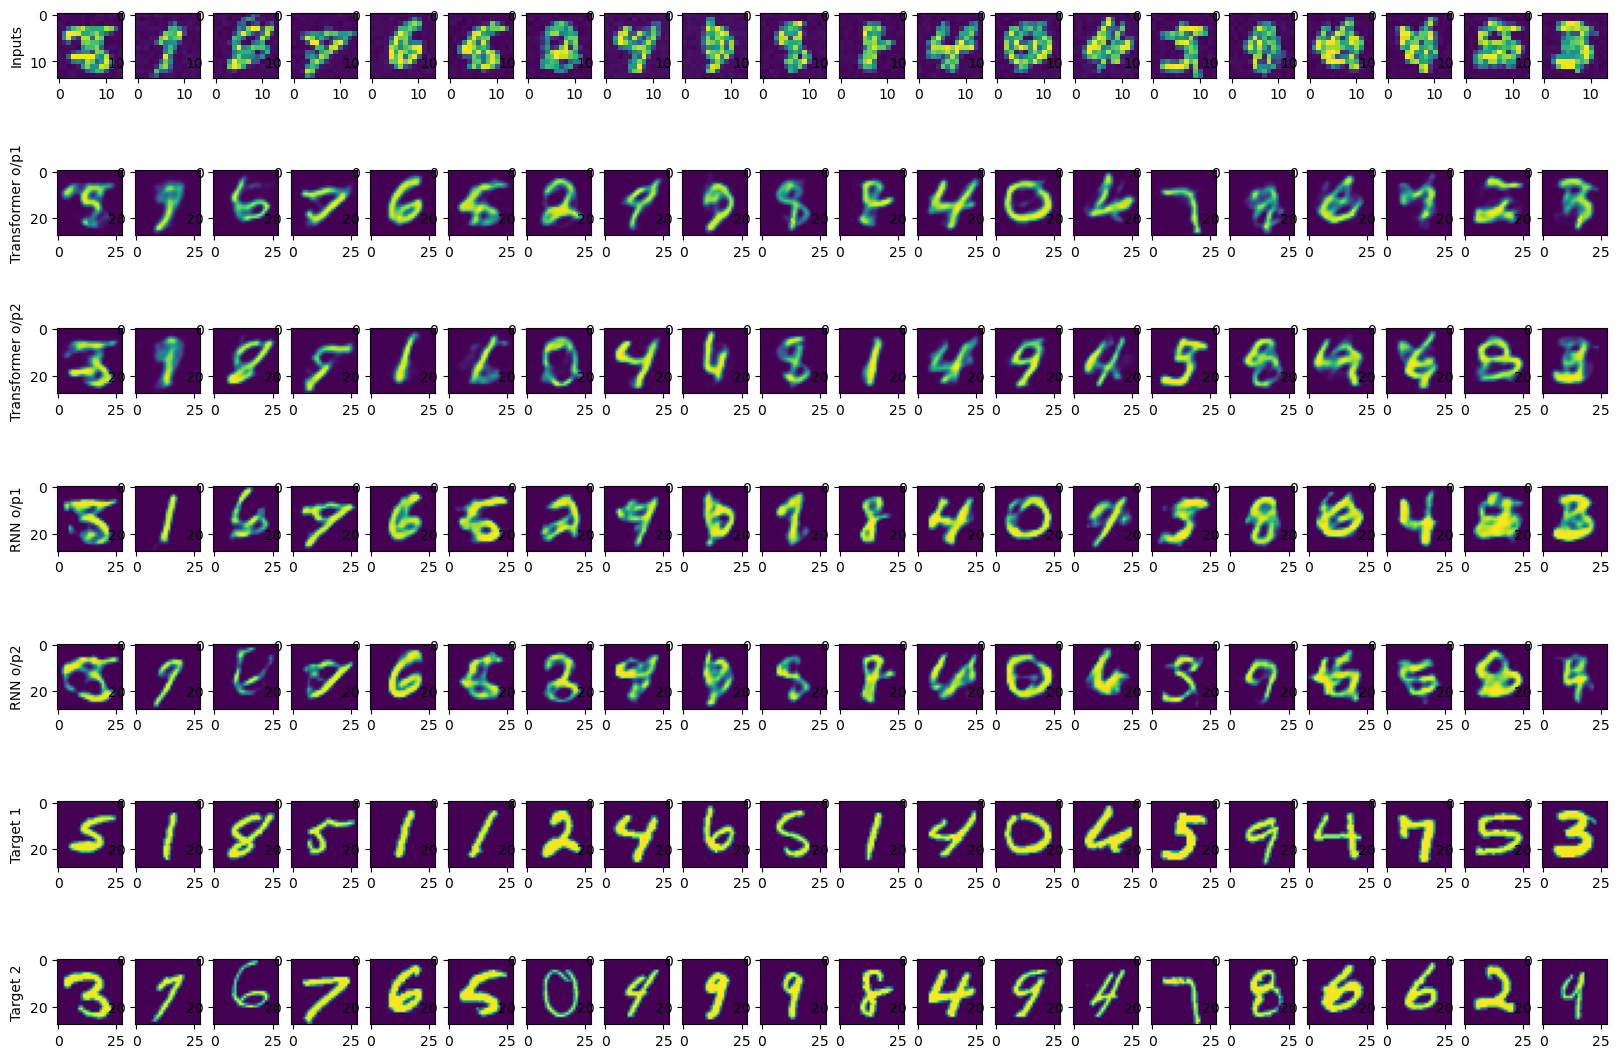

In [5]:
show_outputs_rgb(TransformerOutputs=TransformerOutputs, RNNOutputs= RNNOutputs, targets=targets,inputs= inputs, num_images=20, gray=True)

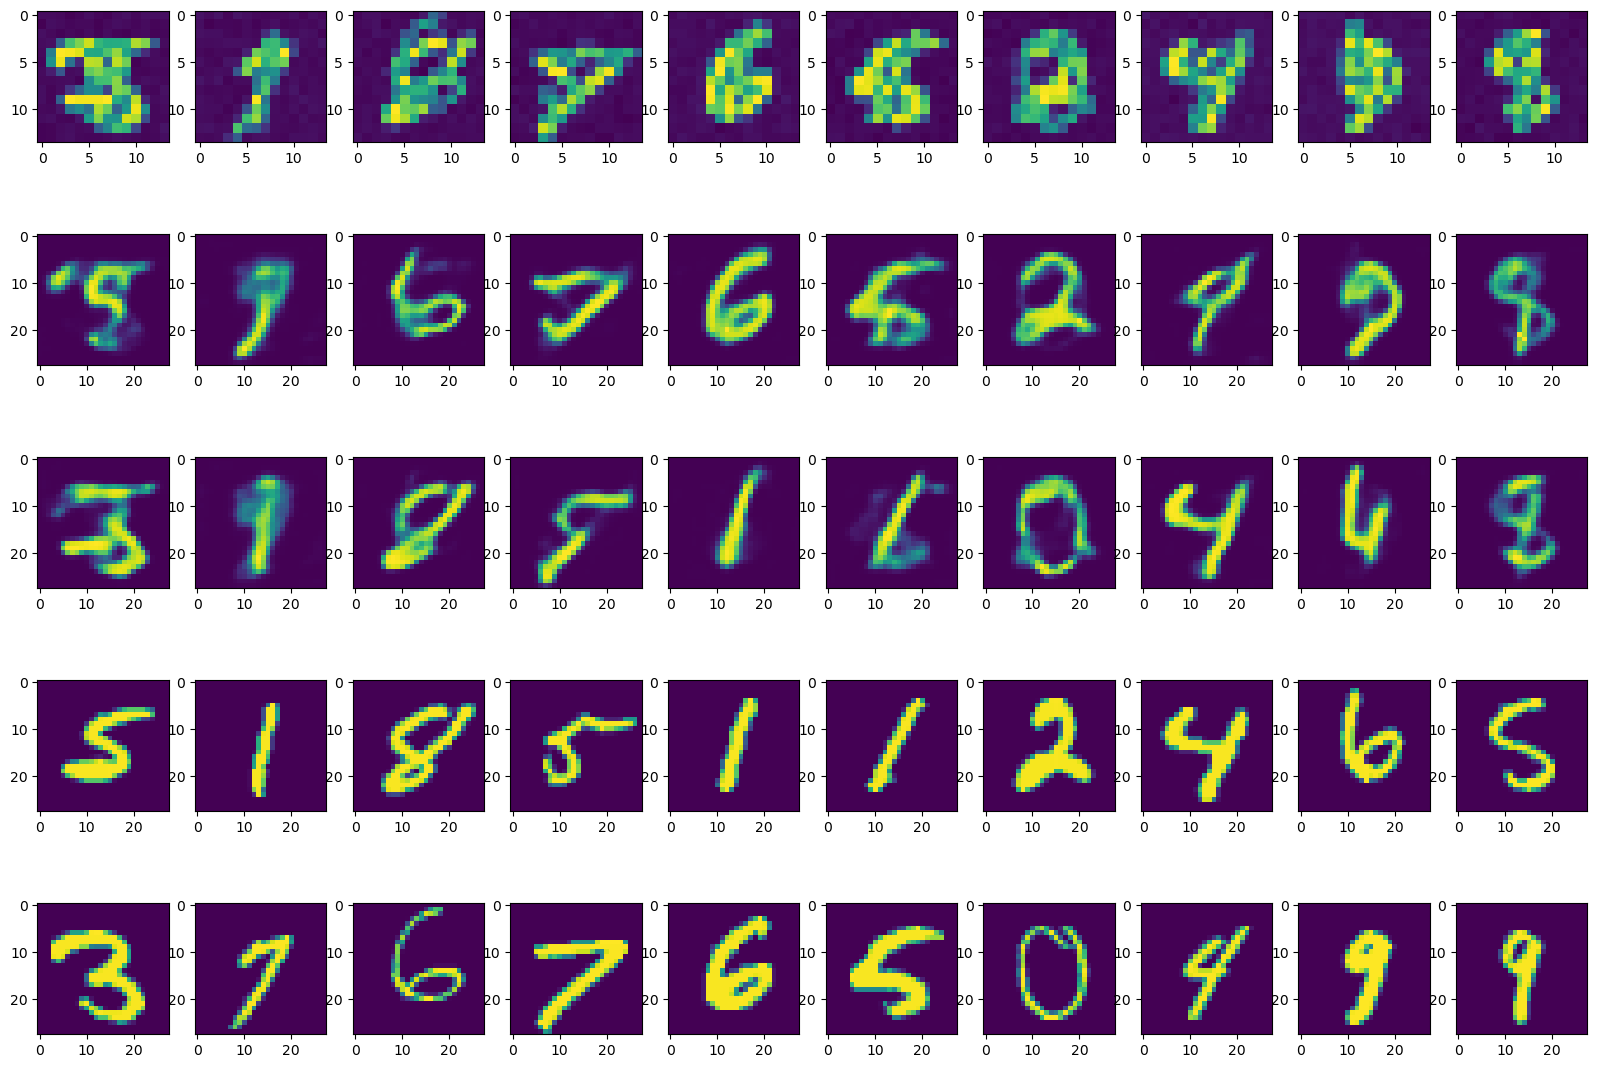

In [6]:
show_outputs(outputs=TransformerOutputs, inputs=inputs, targets=targets, num_images=10)

In [8]:
# Let's collect all of our results with respect to SSIM

from utils import SSIM
similarity = SSIM()


testset = DataLoader(test_supserimposed, batch_size=1, shuffle=True)
criterion = nn.MSELoss()

T_ssim_list, RNN_ssim_list = [], []
T_mse_list, RNN_mse_list = [], []
for inputs, targets in testset:
    TransformerOutputs = UpTransformer(inputs)
    RNNOutputs = UpRNN(inputs, flag = False)
    RNNOutputs = torch.cat([RNNOutputs[1].reshape(-1,1,28,28), RNNOutputs[2].reshape(-1,1,28,28)], axis = 1)
    Transformer_sim_vals, RNN_sim_vals, Transformer_mse_vals,RNN_mse_vals = [], [], [], []
    Transformer_sim_vals.append(similarity(TransformerOutputs[:,0,:,:].unsqueeze(1), targets[:,0,:,:].unsqueeze(1)))
    Transformer_sim_vals.append(similarity(TransformerOutputs[:,1,:,:].unsqueeze(1), targets[:,1,:,:].unsqueeze(1)))
    Transformer_sim_vals.append(similarity(TransformerOutputs[:,0,:,:].unsqueeze(1), targets[:,1,:,:].unsqueeze(1)))
    Transformer_sim_vals.append(similarity(TransformerOutputs[:,1,:,:].unsqueeze(1), targets[:,0,:,:].unsqueeze(1)))
    Transformer_sim_vals.sort()
    RNN_sim_vals.append(similarity(RNNOutputs[:,0,:,:].unsqueeze(1), targets[:,0,:,:].unsqueeze(1)))
    RNN_sim_vals.append(similarity(RNNOutputs[:,1,:,:].unsqueeze(1), targets[:,1,:,:].unsqueeze(1)))
    RNN_sim_vals.append(similarity(RNNOutputs[:,0,:,:].unsqueeze(1), targets[:,1,:,:].unsqueeze(1)))
    RNN_sim_vals.append(similarity(RNNOutputs[:,1,:,:].unsqueeze(1), targets[:,0,:,:].unsqueeze(1)))
    RNN_sim_vals.sort()
    Transformer_sim_vals.sort()
    T_ssim_list.extend(Transformer_sim_vals[-2:])
    RNN_ssim_list.extend(RNN_sim_vals[-2:])
    Transformer_mse_vals.append(criterion(TransformerOutputs[:,0,:,:].unsqueeze(1), targets[:,0,:,:].unsqueeze(1)))
    Transformer_mse_vals.append(criterion(TransformerOutputs[:,1,:,:].unsqueeze(1), targets[:,1,:,:].unsqueeze(1)))
    Transformer_mse_vals.append(criterion(TransformerOutputs[:,0,:,:].unsqueeze(1), targets[:,1,:,:].unsqueeze(1)))
    Transformer_mse_vals.append(criterion(TransformerOutputs[:,1,:,:].unsqueeze(1), targets[:,0,:,:].unsqueeze(1)))
    Transformer_mse_vals.sort()
    RNN_mse_vals.append(criterion(RNNOutputs[:,0,:,:].unsqueeze(1), targets[:,0,:,:].unsqueeze(1)))
    RNN_mse_vals.append(criterion(RNNOutputs[:,1,:,:].unsqueeze(1), targets[:,1,:,:].unsqueeze(1)))
    RNN_mse_vals.append(criterion(RNNOutputs[:,0,:,:].unsqueeze(1), targets[:,1,:,:].unsqueeze(1)))
    RNN_mse_vals.append(criterion(RNNOutputs[:,1,:,:].unsqueeze(1), targets[:,0,:,:].unsqueeze(1)))
    RNN_mse_vals.sort()
    Transformer_sim_vals.sort()
    T_ssim_list.extend(Transformer_sim_vals[-2:])
    RNN_ssim_list.extend(RNN_sim_vals[-2:])




KeyboardInterrupt: 

In [ ]:
# Let's plot the SSIM values
